In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!unzip -q "/content/drive/My Drive/data/tiny-imagenet-200.zip"

replace tiny-imagenet-200/words.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
### Imports ###
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard
from keras.engine.topology import Network
from keras.layers import *
from keras.models import Model
from keras.preprocessing import image
import keras.backend as K

import matplotlib.pyplot as plt
import tensorflow as tf

import numpy as np
import os
import random
import scipy.misc
from tqdm import *

%matplotlib inline

In [ ]:
### Constants ###
DATA_DIR = "/content/tiny-imagenet-200"
TRAIN_DIR = os.path.join(DATA_DIR, "train")
TEST_DIR = os.path.join(DATA_DIR, "test")

IMG_SHAPE = (64, 64)

In [ ]:
def load_dataset_small(num_images_per_class_train=100, num_images_test=5000):
    """Loads training and test datasets, from Tiny ImageNet Visual Recogition Challenge.

    Arguments:
        num_images_per_class_train: number of images per class to load into training dataset.
        num_images_test: total number of images to load into training dataset.
    """
    X_train = []
    X_test = []
    
    # Create training set.
    for c in os.listdir(TRAIN_DIR):
        c_dir = os.path.join(TRAIN_DIR, c, 'images')
        c_imgs = os.listdir(c_dir)
        random.shuffle(c_imgs)
        #for img_name_i in c_imgs[0:num_images_per_class_train]:
        for img_name_i in c_imgs:
            img_i = image.load_img(os.path.join(c_dir, img_name_i))
            x = image.img_to_array(img_i)
            X_train.append(x)
    random.shuffle(X_train)
    
    # Create test set.
    test_dir = os.path.join(TEST_DIR, 'images')
    test_imgs = os.listdir(test_dir)
    random.shuffle(test_imgs)
    #for img_name_i in test_imgs[0:num_images_test]:
    for img_name_i in test_imgs:
        img_i = image.load_img(os.path.join(test_dir, img_name_i))
        x = image.img_to_array(img_i)
        X_test.append(x)

    # Return train and test data as numpy arrays.
    return np.array(X_train), np.array(X_test)

In [ ]:
# Load dataset.
X_train, X_test= load_dataset_small()

# Normalize image vectors.
# X_train = X_train_orig/255.
# X_test = X_test_orig/255.

# Print statistics.
print ("Number of training examples = " + str(X_train.shape[0]))
print ("Number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape)) # Should be (train_size, 64, 64, 3).

Number of training examples = 100000
Number of test examples = 10000
X_train shape: (100000, 64, 64, 3)


In [ ]:
# We split training set into two halfs.
# First half is used for training as secret images, second half for cover images.

# S: secret image
input_S = X_train[0:X_train.shape[0] // 2]

# C: cover image
input_C = X_train[X_train.shape[0] // 2:]

In [ ]:
# Variable used to weight the losses of the secret and cover images (See paper for more details)
beta = 1.0

# Loss for reveal network
def rev_loss(y_true, y_pred):
    # Loss for reveal network is: beta * |S-S'|
    return K.mean(K.square(y_true - y_pred))

# Loss for the full model, used for preparation and hidding networks
def full_loss(y_true, y_pred):
    # Loss for the full model is: |C-C'| + beta * |S-S'|
    s_true, c_true = y_true[:,:,:,0:3], y_true[:,:,:,3:6]
    s_pred, c_pred = y_pred[:,:,:,0:3], y_pred[:,:,:,3:6]
    s_loss = K.mean(K.square(s_true - s_pred))
    c_loss = K.mean(K.square(c_true - c_pred))
    return s_loss + c_loss


# Returns the encoder as a Keras model, composed by Preparation and Hiding Networks.
def make_encoder(input_size):
    input_S = Input(shape=(input_size))
    input_C= Input(shape=(input_size))
    input_K= Input(shape=(input_size))

   
    x = tf.bitwise.bitwise_xor(tf.cast(input_S, tf.bool), tf.cast(input_K, tf.bool))
    x = tf.math.truediv(tf.cast(x, tf.float32), 255.0)
  
    # input_K = Input(shape=(81,)) #changed
    # filter = Reshape((3, 3, 3, 3))(input_K)
    # x = tf.nn.conv2d(input_S, filter, strides = (1, 1, 1, 1), padding='VALID')

    # x = tf.map_fn(xor,input_S,input_K)
    #x = Lambda(vXor(input_S, input_K))

    # Preparation Network
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_3x3')(x) #changed
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_4x4')(x) #changed
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_5x5')(x) #changed
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_5x5')(x)
    x = concatenate([x3, x4, x5])

    y = tf.math.truediv(input_C, 255.0)
    
    x = concatenate([y, x])
    
    # Hiding network
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid3_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid3_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid3_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid4_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid4_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid5_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x = Conv2D(3, (3, 3), strides = (1, 1), padding='same', activation='relu', name='output_C')(x)
    output_Cprime = tf.math.multiply(x, 255.0)
    return Model(inputs=[input_S, input_C, input_K], #changed
                 outputs=output_Cprime,
                 name = 'Encoder')

# Returns the decoder as a Keras model, composed by the Reveal Network
def make_decoder(input_size, fixed=False):
    
    # Reveal network
    reveal_input = Input(shape=(input_size))
    input_K = Input(shape=(input_size))
  

    # Adding Gaussian noise with 0.01 standard deviation.
    x = GaussianNoise(0.01, name='output_C_noise')(reveal_input) #changed
    x = tf.bitwise.bitwise_xor(tf.cast(x, tf.int32), tf.cast(input_K, tf.int32))
    x = tf.cast(x, tf.float32)
    x = tf.math.truediv(reveal_input,255.0)
    
    # input_K = Input(shape=(81,))
    # filter = Reshape((3, 3, 3, 3))(input_K)
    # x = tf.nn.conv2d(input_with_noise, filter, strides = (1, 1, 1, 1), padding='VALID')
    # x = tf.bitwise.bitwise_xor(input_with_noise, bytearray(input_K))
  
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_3x3')(x) #changed
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev4_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev4_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev5_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x = Conv2D(3, (3, 3), strides = (1, 1), padding='same', activation='relu', name='output_S')(x)
    output_Sprime  = tf.math.multiply(x, 255.0)
    # x = tf.math.multiply(x, 255.0)
    # x = tf.bitwise.bitwise_xor(tf.cast(x, tf.int32), tf.cast(input_K, tf.int32))
    # x = tf.cast(x, tf.float32)
    # output_Sprime = Conv2D(3, (3, 3), strides = (1, 1), padding='same', activation='relu', name='output_Extra')(x)
    
    
    
    if not fixed:
        return Model(inputs=[reveal_input,input_K],
                     outputs=output_Sprime,
                     name = 'Decoder')
    # else:
    #     return Container(inputs=reveal_input,
    #                      outputs=output_Sprime,
    #                      name = 'DecoderFixed')                    # Changed
    else:
      return Network(inputs=[reveal_input,input_K],   #changed
                      outputs=output_Sprime,
                      name = 'DecoderFixed')

# Full model.
def make_model(input_size):
    input_S = Input(shape=(input_size))
    input_C= Input(shape=(input_size)) 
    input_K = Input(shape=(input_size))  #changed
    
    encoder = make_encoder(input_size)
    
    decoder = make_decoder(input_size)
    decoder.compile(optimizer='adam', loss=rev_loss)
    decoder.trainable = False
    
    output_Cprime = encoder([input_S, input_C, input_K]) #changed
    output_Sprime = decoder([output_Cprime, input_K]) #changed

    autoencoder = Model(inputs=[input_S, input_C, input_K],
                        outputs=concatenate([output_Sprime, output_Cprime]))
    autoencoder.compile(optimizer='adam', loss=full_loss)
    return encoder, decoder, autoencoder

In [ ]:
def lr_schedule(epoch_idx):
    if epoch_idx < 200:
        return 0.001
    elif epoch_idx < 400:
        return 0.0003
    elif epoch_idx < 600:
        return 0.0001
    else:
        return 0.00003

### For 1st 50 epoch :

In [ ]:
import bitstring
from bitstring import *

def xor(x1, x2) :
  a = BitArray(float=x1, length = 64)
  b = BitArray(float=x2, length = 64)
  a ^= b
  return a.float
vXor = np.vectorize(xor)

In [ ]:
def Train(e):
  NB_EPOCHS = e
  BATCH_SIZE = 32
  m = input_S.shape[0]
  ae_loss_history = []
  rev_loss_history = []
  encoder_model, reveal_model, autoencoder_model = make_model(input_S.shape[1:])
  for epoch in range(NB_EPOCHS):
      np.random.shuffle(input_S)
      np.random.shuffle(input_C)
      
      t = tqdm(range(0, input_S.shape[0], BATCH_SIZE),mininterval=0)
      ae_loss = []
      rev_loss = []
      for idx in t:
          
          batch_S = input_S[idx:min(idx + BATCH_SIZE, m)]
          batch_C = input_C[idx:min(idx + BATCH_SIZE, m)]
          batch_len = len(batch_S)
          batch_K = np.random.randint(256, size=(batch_len, 64, 64, 3))
      

          #batch_encrypted_S = np.empty(shape = (batch_len, 64, 64, 3))
          # for i in range(batch_len):
          #   batch_encrypted_S[i:] = vXor(batch_S[i:], batch_K[i:])
          #batch_encrypted_S = vXor(batch_S, batch_K)

          
          #C_prime = encoder_model.predict([batch_encrypted_S, batch_C])
          C_prime = encoder_model.predict([batch_S, batch_C, batch_K])
          #batch_encrypted_C_prime = np.empty(shape =(batch_len, 64, 64, 3))
          #batch_encrypted_C_prime = vXor(C_prime, batch_K)
          # for i in range(batch_len):
          #   batch_encrypted_C_prime[i:] = vXor(C_prime[i:], batch_K[i:])
          #print(C_prime)
          #C_prime = C_prime*255.0
      
          #C_prime = np.clip(C_prime,0, 255)
          ae_loss.append(autoencoder_model.train_on_batch(x=[batch_S, batch_C, batch_K], y=np.concatenate((batch_S, batch_C),axis=3)))
          rev_loss.append(reveal_model.train_on_batch(x=[C_prime,batch_K],y=batch_S))
          
          # Update learning rate
          K.set_value(autoencoder_model.optimizer.lr, lr_schedule(epoch))
          K.set_value(reveal_model.optimizer.lr, lr_schedule(epoch))
          
          t.set_description('Epoch {} | Batch: {:3} of {}. Loss AE {:10.2f} | Loss Rev {:10.2f}'.format(epoch + 1, idx, m, np.mean(ae_loss), np.mean(rev_loss)))
      ae_loss_history.append(np.mean(ae_loss))
      rev_loss_history.append(np.mean(rev_loss))
  return ae_loss_history, rev_loss_history, encoder_model, reveal_model, autoencoder_model 

Epoch 1 | Batch: 49984 of 50000. Loss AE    5178.64 | Loss Rev    5029.23: 100%|██████████| 1563/1563 [07:11<00:00,  3.62it/s]
Epoch 2 | Batch: 49984 of 50000. Loss AE    4971.23 | Loss Rev    4951.96: 100%|██████████| 1563/1563 [06:39<00:00,  3.91it/s]
Epoch 3 | Batch: 49984 of 50000. Loss AE    4955.01 | Loss Rev    4945.64: 100%|██████████| 1563/1563 [06:37<00:00,  3.93it/s]
Epoch 4 | Batch: 49984 of 50000. Loss AE    4954.44 | Loss Rev    4943.58: 100%|██████████| 1563/1563 [06:38<00:00,  3.92it/s]
Epoch 5 | Batch: 49984 of 50000. Loss AE    4949.65 | Loss Rev    4941.05: 100%|██████████| 1563/1563 [06:40<00:00,  3.91it/s]
Epoch 6 | Batch: 49984 of 50000. Loss AE    4994.56 | Loss Rev    4939.61: 100%|██████████| 1563/1563 [06:39<00:00,  3.91it/s]
Epoch 7 | Batch: 49984 of 50000. Loss AE    4947.70 | Loss Rev    4936.86: 100%|██████████| 1563/1563 [06:37<00:00,  3.93it/s]
Epoch 8 | Batch: 49984 of 50000. Loss AE    4943.91 | Loss Rev    4936.93: 100%|██████████| 1563/1563 [06:37<00

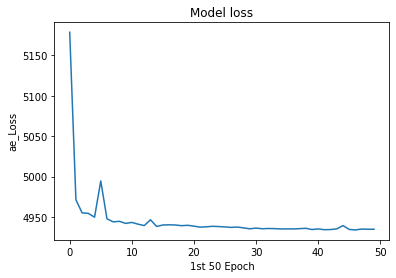

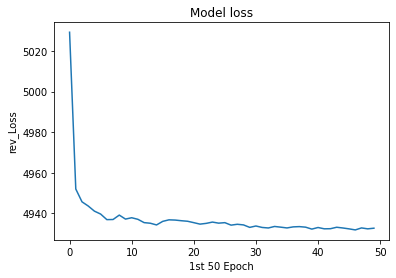

In [ ]:
ae_loss_history, rev_loss_history, encoder_model, reveal_model, autoencoder_model = Train(50)
autoencoder_model.save_weights('/content/drive/My Drive/Model/Sym_autoencoder_model_image_key_xor_100k_50e.hdf5')
encoder_model.save_weights('/content/drive/My Drive/Model/Sym_encoder_model_image_key_xor_100k_50e.hdf5')
reveal_model.save_weights('/content/drive/My Drive/Model/Sym_reveal_model_image_key_xor_100k_50e.hdf5')
plt.plot(ae_loss_history)
plt.title('Model loss')
plt.ylabel('ae_Loss')
plt.xlabel('1st 50 Epoch')
plt.show()
plt.plot(rev_loss_history)
plt.title('Model loss')
plt.ylabel('rev_Loss')
plt.xlabel('1st 50 Epoch')
plt.show()

In [ ]:
!pip install bitstring

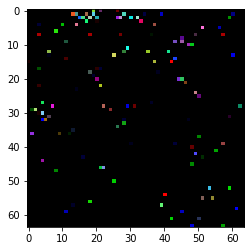

In [ ]:
import bitstring
import matplotlib.pyplot as plt

from bitstring import *
def xor(x1, x2) :
  a = BitArray(float=x1, length = 64)
  b = BitArray(float=x2, length = 64)
  a ^= b
  return a.float
vfunc = np.vectorize(xor)
batch_K = np.random.randint(256, size=( 64, 64, 3))
batch_K = batch_K/255.
encrypted = vfunc(X_train[0], batch_K)
plt.imshow(encrypted)

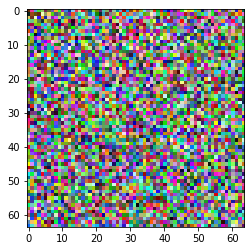

In [ ]:
plt.imshow(batch_K)

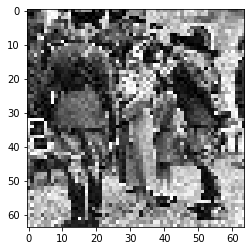

In [ ]:
plt.imshow(X_train[0])

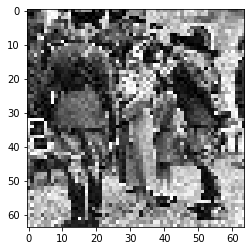

In [ ]:
decrypted = vfunc(encrypted, batch_K)
plt.imshow(decrypted)

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2192: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/usr/local/lib/python3.7/dist-packages/matplotlib/cm.py:229: RuntimeWarning: invalid value encountered in multiply
  xx = (xx * 255).astype(np.uint8)


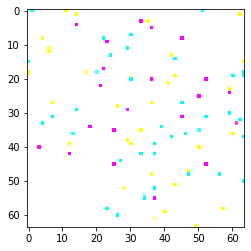

In [ ]:
wrong_batch_K = np.random.randint(256, size=( 64, 64, 3))
wrong_decrypted = vfunc(encrypted, wrong_batch_K)
plt.imshow(wrong_decrypted)

### Test Code 

In [ ]:
# S: secret image
input_S = X_test[0:X_test.shape[0] // 2]

# C: cover image
input_C = X_test[X_test.shape[0] // 2:]

In [ ]:
encoder_model, reveal_model, autoencoder_model = make_model(input_S.shape[1:])
autoencoder_model.load_weights('/content/drive/My Drive/Model/Sym_autoencoder_model_image_key_xor_100k_50e.hdf5')
encoder_model.load_weights('/content/drive/My Drive/Model/Sym_encoder_model_image_key_xor_100k_50e.hdf5')
reveal_model.save_weights('/content/drive/My Drive/Model/Sym_reveal_model_image_key_xor_100k_50e.hdf5')
secret=X_test[1]
cover=X_test[2]
test_actual_K = np.random.randint(256, size=(1,64,64,3))
test_wrong_K = np.random.randint(256, size=(1, 64,64,3))
C_prime = encoder_model.predict([np.array([secret]), np.array([cover]), test_actual_K])
Reveal_actual = reveal_model.predict([C_prime, test_actual_K])
Reveal_wrong = reveal_model.predict([C_prime, test_wrong_K])

NameError: ignored

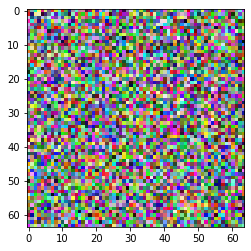

In [ ]:
plt.imshow(test_actual_K[0]/255.0)
plt.show()

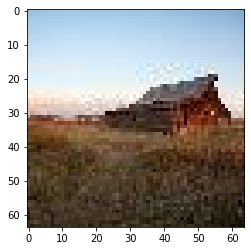

In [ ]:
plt.imshow(secret/255.0)
plt.show()

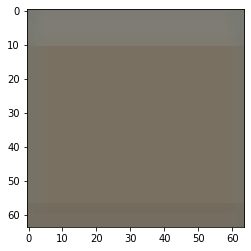

In [ ]:
plt.imshow(Reveal_actual[0]/255.0)
plt.show()

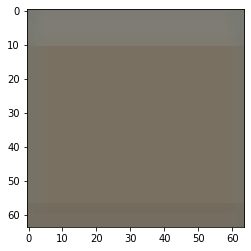

In [ ]:
plt.imshow(Reveal_wrong[0]/255.0)
plt.show()

In [ ]:
# Retrieve decoded predictions.
np.random.seed(21)
test_K = np.random.randint(256, size=(len(input_S), 64,64,3))
decoded = autoencoder_model.predict([input_S, input_C, test_K])
decoded_S, decoded_C = decoded[...,0:3], decoded[...,3:6]
# Get absolute difference between the outputs and the expected values.
diff_S, diff_C = np.abs(decoded_S - input_S), np.abs(decoded_C - input_C) 

In [ ]:
def pixel_errors(input_S, input_C, decoded_S, decoded_C):
    """Calculates mean of Sum of Squared Errors per pixel for cover and secret images. """
    see_Spixel = np.sqrt(np.mean(np.square(255*(input_S - decoded_S))))
    see_Cpixel = np.sqrt(np.mean(np.square(255*(input_C - decoded_C))))
    
    return see_Spixel, see_Cpixel

def pixel_histogram(diff_S, diff_C):
    """Calculates histograms of errors for cover and secret image. """
    diff_Sflat = diff_S.flatten()
    diff_Cflat = diff_C.flatten()
    
    fig = plt.figure(figsize=(15, 5))
    a=fig.add_subplot(1,2,1)
        
    imgplot = plt.hist(255* diff_Cflat, 100, density=True, alpha=0.75, color='red')
    a.set_title('Distribution of error in the Cover image.')
    plt.axis([0, 250, 0, 0.2])
    
    a=fig.add_subplot(1,2,2)
    imgplot = plt.hist(255* diff_Sflat, 100, density=True, alpha=0.75, color='red')
    a.set_title('Distribution of errors in the Secret image.')
    plt.axis([0, 250, 0, 0.2])
    
    plt.show()

In [ ]:
# Print pixel-wise average errors in a 256 scale.
S_error, C_error = pixel_errors(input_S, input_C, decoded_S, decoded_C)

print ("S error per pixel [0, 255]:", S_error)
print ("C error per pixel [0, 255]:", C_error)

S error per pixel [0, 255]: 17841.463
C error per pixel [0, 255]: 433.71323


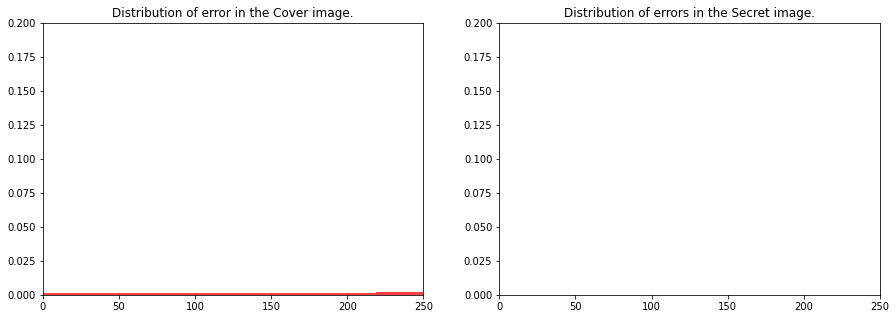

In [ ]:
pixel_histogram(diff_S, diff_C)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

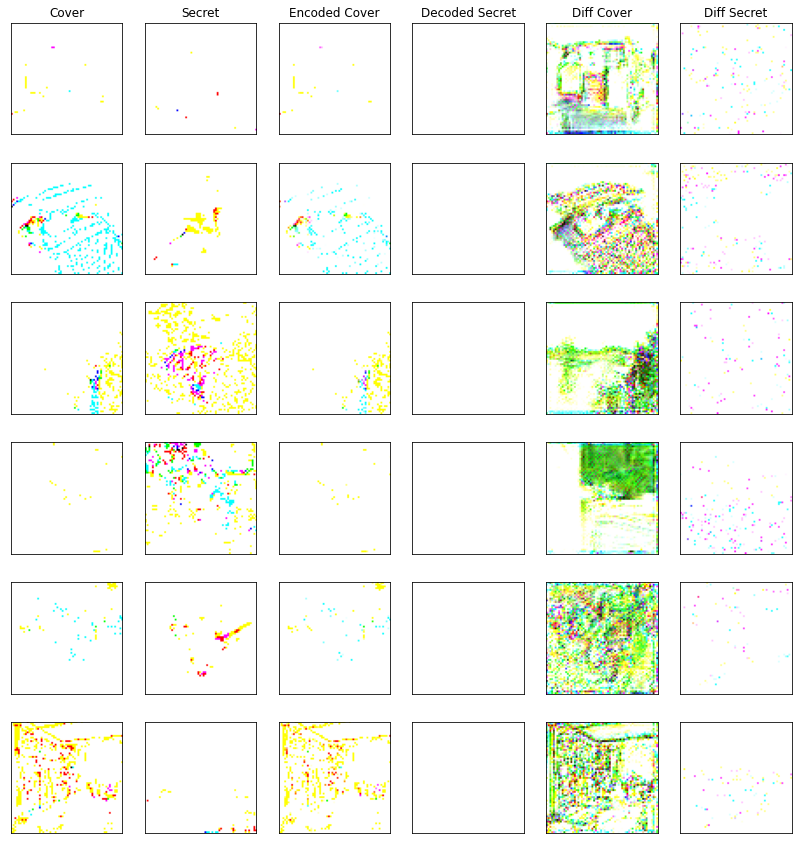

In [ ]:
# Configs for results display

# Show images in gray scale
SHOW_GRAY = False
# Show difference bettwen predictions and ground truth.
SHOW_DIFF = True

# Diff enhance magnitude
ENHANCE = 1

# Number of secret and cover pairs to show.
n = 6

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

def show_image(img, n_rows, n_col, idx, gray=False, first_row=False, title=None):
    ax = plt.subplot(n_rows, n_col, idx)
    if gray:
        plt.imshow(rgb2gray(img), cmap = plt.get_cmap('gray'))
    else:
        plt.imshow(img)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if first_row:
        plt.title(title)

plt.figure(figsize=(14, 15))
rand_indx = [random.randint(0, 1000) for x in range(n)]
# for i, idx in enumerate(range(0, n)):
for i, idx in enumerate(rand_indx):
    n_col = 6 if SHOW_DIFF else 4
    
    show_image(input_C[idx], n, n_col, i * n_col + 1, gray=SHOW_GRAY, first_row=i==0, title='Cover')

    show_image(input_S[idx], n, n_col, i * n_col + 2, gray=SHOW_GRAY, first_row=i==0, title='Secret')
    
    show_image(decoded_C[idx], n, n_col, i * n_col + 3, gray=SHOW_GRAY, first_row=i==0, title='Encoded Cover')
    
    show_image(decoded_S[idx], n, n_col, i * n_col + 4, gray=SHOW_GRAY, first_row=i==0, title='Decoded Secret')

    
    if SHOW_DIFF:
        show_image(np.multiply(diff_C[idx], ENHANCE), n, n_col, i * n_col + 5, gray=SHOW_GRAY, first_row=i==0, title='Diff Cover')
        
        show_image(np.multiply(diff_S[idx], ENHANCE), n, n_col, i * n_col + 6, gray=SHOW_GRAY, first_row=i==0, title='Diff Secret')

plt.show()

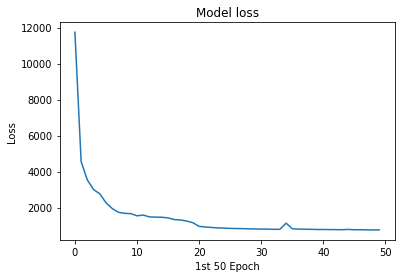

In [ ]:
plt.plot(loss_history)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('1st 50 Epoch')
plt.show()

In [ ]:
def lr_schedule(epoch_idx):
    if epoch_idx < 200:
        return 0.001
    elif epoch_idx < 400:
        return 0.0003
    elif epoch_idx < 600:
        return 0.0001
    else:
        return 0.00003

### Try with bool

In [ ]:
ae_loss_history, rev_loss_history, encoder_model, reveal_model, autoencoder_model = Train(1)
autoencoder_model.save_weights('/content/drive/My Drive/Model/Sym_autoencoder_model_image_key_bool_xor_100k_e.hdf5')
encoder_model.save_weights('/content/drive/My Drive/Model/Sym_encoder_model_image_key_bool_xor_100k_e.hdf5')
reveal_model.save_weights('/content/drive/My Drive/Model/Sym_reveal_model_image_key_bool_xor_100k_e.hdf5')
plt.plot(ae_loss_history)
plt.title('Model loss')
plt.ylabel('ae_Loss')
plt.xlabel('1st 50 Epoch')
plt.show()
plt.plot(rev_loss_history)
plt.title('Model loss')
plt.ylabel('rev_Loss')
plt.xlabel('1st 50 Epoch')
plt.show()

TypeError: ignored

### TRy with py wrapper

In [ ]:
import bitstring
from bitstring import *

def xor(x1, x2) :
  a = BitArray(float=x1, length = 64)
  b = BitArray(float=x2, length = 64)
  a ^= b
  return a.float
vXor = np.vectorize(xor)

In [ ]:
import bitstring
from bitstring import *

def xor1(x1, x2) :
  a = BitArray(float=x1, length = 64)
  b = BitArray(float=x2, length = 64)
  a ^= b
  return a.float
vXor1 = np.vectorize(xor1)

In [ ]:
def vXor(x1, x2) :
 return lambda x1, x2 : (BitArray(float=x1, length = 64) ^ BitArray(float=x2, length = 64)).float


In [ ]:
def floatToBitArray(x) :
  print(x)
  print(",...............................")
  print(x)
  return BitArray(float(x), length = 64)

def vXor(x1, x2) :
  a = tf.vectorized_map(floatToBitArray, x1)
  b = tf.vectorized_map(floatToBitArray, x2)
  print(".....................................................")
  a ^= b
  return a.float

In [ ]:
def vXor(x1, x2) :
  a = BitArray(float=x1, length = 64)
  b = BitArray(float=x2, length = 64)
  a ^= b
  return a.float
np

In [ ]:
from bitstring import BitArray

In [ ]:
y = tf.py_function(func=log_huber, inp=[x, m], Tout=tf.float32)

In [ ]:
# We split training set into two halfs.
# First half is used for training as secret images, second half for cover images.

# S: secret image
input_S = X_train[0:X_train.shape[0] // 2]

# C: cover image
input_C = X_train[X_train.shape[0] // 2:]

In [ ]:
# Load dataset.
X_train, X_test= load_dataset_small()

# Normalize image vectors.
X_train = X_train/255.
X_test = X_test/255.

# Print statistics.
print ("Number of training examples = " + str(X_train.shape[0]))
print ("Number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape)) # Should be (train_size, 64, 64, 3).

Number of training examples = 100000
Number of test examples = 10000
X_train shape: (100000, 64, 64, 3)


In [ ]:
# Variable used to weight the losses of the secret and cover images (See paper for more details)
beta = 1.0

# Loss for reveal network
def rev_loss(y_true, y_pred):
    # Loss for reveal network is: beta * |S-S'|
    return K.mean(K.square(y_true - y_pred))

# Loss for the full model, used for preparation and hidding networks
def full_loss(y_true, y_pred):
    # Loss for the full model is: |C-C'| + beta * |S-S'|
    s_true, c_true = y_true[:,:,:,0:3], y_true[:,:,:,3:6]
    s_pred, c_pred = y_pred[:,:,:,0:3], y_pred[:,:,:,3:6]
    s_loss = rev_loss(s_true,s_pred)
    c_loss = rev_loss(c_true,c_pred)
    return s_loss + c_loss


# Returns the encoder as a Keras model, composed by Preparation and Hiding Networks.
def make_encoder(input_size):
    input_S = Input(shape=(input_size))
    input_C= Input(shape=(input_size))
    input_K= Input(shape=(input_size))

   
    # x = tf.bitwise.bitwise_xor(tf.cast(input_S, tf.bool), tf.cast(input_K, tf.bool))
    # x = tf.math.truediv(tf.cast(x, tf.float32), 255.0)
  
    # input_K = Input(shape=(81,)) #changed
    # filter = Reshape((3, 3, 3, 3))(input_K)
    # x = tf.nn.conv2d(input_S, filter, strides = (1, 1, 1, 1), padding='VALID')

    # x = tf.map_fn(xor,input_S,input_K)
    #x = Lambda(vXor(input_S, input_K))

    x = tf.py_function(func=vXor, inp=[input_S, input_K], Tout=tf.float32)
    x.set_shape(input_S.get_shape())
    # x = tf.vectorized_map(vXor, [input_S, input_K])

    # Preparation Network
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_3x3')(x) #changed
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_4x4')(x) #changed
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_5x5')(x) #changed
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_5x5')(x)
    x = concatenate([x3, x4, x5])

    # y = tf.math.truediv(input_C, 255.0)
    
    x = concatenate([input_C, x])
    
    # Hiding network
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid3_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid3_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid3_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid4_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid4_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid5_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    output_Cprime = Conv2D(3, (3, 3), strides = (1, 1), padding='same', activation='relu', name='output_C')(x)
    # output_Cprime = tf.math.multiply(x, 255.0)
    return Model(inputs=[input_S, input_C, input_K], #changed
                 outputs=output_Cprime,
                 name = 'Encoder')

# Returns the decoder as a Keras model, composed by the Reveal Network
def make_decoder(input_size, fixed=False):
    
    # Reveal network
    reveal_input = Input(shape=(input_size))
    input_K = Input(shape=(input_size))
  

    # Adding Gaussian noise with 0.01 standard deviation.
    x = GaussianNoise(0.01, name='output_C_noise')(reveal_input) #changed
    x = tf.py_function(func=vXor, inp=[x, input_K], Tout=tf.float32)
    x.set_shape(reveal_input.get_shape())
    # x = tf.vectorized_map(vXor, [input_S, input_K])
    # x = tf.bitwise.bitwise_xor(tf.cast(x, tf.int32), tf.cast(input_K, tf.int32))
    # x = tf.cast(x, tf.float32)
    # x = tf.math.truediv(reveal_input,255.0)
    
    # input_K = Input(shape=(81,))
    # filter = Reshape((3, 3, 3, 3))(input_K)
    # x = tf.nn.conv2d(input_with_noise, filter, strides = (1, 1, 1, 1), padding='VALID')
    # x = tf.bitwise.bitwise_xor(input_with_noise, bytearray(input_K))
  
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_3x3')(x) #changed
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev4_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev4_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev5_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    output_Sprime = Conv2D(3, (3, 3), strides = (1, 1), padding='same', activation='relu', name='output_S')(x)
    # output_Sprime  = tf.math.multiply(x, 255.0)
    # x = tf.math.multiply(x, 255.0)
    # x = tf.bitwise.bitwise_xor(tf.cast(x, tf.int32), tf.cast(input_K, tf.int32))
    # x = tf.cast(x, tf.float32)
    # output_Sprime = Conv2D(3, (3, 3), strides = (1, 1), padding='same', activation='relu', name='output_Extra')(x)
    
    
    
    if not fixed:
        return Model(inputs=[reveal_input,input_K],
                     outputs=output_Sprime,
                     name = 'Decoder')
    # else:
    #     return Container(inputs=reveal_input,
    #                      outputs=output_Sprime,
    #                      name = 'DecoderFixed')                    # Changed
    else:
      return Network(inputs=[reveal_input,input_K],   #changed
                      outputs=output_Sprime,
                      name = 'DecoderFixed')

# Full model.
def make_model(input_size):
    input_S = Input(shape=(input_size))
    input_C= Input(shape=(input_size)) 
    input_K = Input(shape=(input_size))  #changed
    
    encoder = make_encoder(input_size)
    
    decoder = make_decoder(input_size)
    decoder.compile(optimizer='adam', loss=rev_loss)
    decoder.trainable = False
    
    output_Cprime = encoder([input_S, input_C, input_K]) #changed
    output_Sprime = decoder([output_Cprime, input_K]) #changed

    autoencoder = Model(inputs=[input_S, input_C, input_K],
                        outputs=concatenate([output_Sprime, output_Cprime]))
    autoencoder.compile(optimizer='adam', loss=full_loss)
    return encoder, decoder, autoencoder

In [ ]:

NB_EPOCHS = 1
BATCH_SIZE = 32
m = input_S.shape[0]
ae_loss_history = []
rev_loss_history = []
encoder_model, reveal_model, autoencoder_model = make_model(input_S.shape[1:])
for epoch in range(NB_EPOCHS):
    np.random.shuffle(input_S)
    np.random.shuffle(input_C)
    
    t = tqdm(range(0, input_S.shape[0], BATCH_SIZE),mininterval=0)
    ae_loss = []
    rev_loss = []
    for idx in t:
        
        batch_S = input_S[idx:min(idx + BATCH_SIZE, m)]
        batch_C = input_C[idx:min(idx + BATCH_SIZE, m)]
        batch_len = len(batch_S)
        batch_K = np.random.randint(256, size=(batch_len, 64, 64, 3))
        batch_K = batch_K /255.
    

        #batch_encrypted_S = np.empty(shape = (batch_len, 64, 64, 3))
        # for i in range(batch_len):
        #   batch_encrypted_S[i:] = vXor(batch_S[i:], batch_K[i:])
        #batch_encrypted_S = vXor(batch_S, batch_K)

        
        #C_prime = encoder_model.predict([batch_encrypted_S, batch_C])
        C_prime = encoder_model.predict([batch_S, batch_C, batch_K])
    
        
        #batch_encrypted_C_prime = np.empty(shape =(batch_len, 64, 64, 3))
        #batch_encrypted_C_prime = vXor(C_prime, batch_K)
        # for i in range(batch_len):
        #   batch_encrypted_C_prime[i:] = vXor(C_prime[i:], batch_K[i:])
        #print(C_prime)
        #C_prime = C_prime*255.0
    
        #C_prime = np.clip(C_prime,0, 255)
        ae_loss.append(autoencoder_model.train_on_batch(x=[batch_S, batch_C, batch_K], y=np.concatenate((batch_S, batch_C),axis=3)))
        rev_loss.append(reveal_model.train_on_batch(x=[C_prime,batch_K],y=batch_S))
        
        # Update learning rate
        K.set_value(autoencoder_model.optimizer.lr, lr_schedule(epoch))
        K.set_value(reveal_model.optimizer.lr, lr_schedule(epoch))
        
        t.set_description('Epoch {} | Batch: {:3} of {}. Loss AE {:10.2f} | Loss Rev {:10.2f}'.format(epoch + 1, idx, m, np.mean(ae_loss), np.mean(rev_loss)))
    ae_loss_history.append(np.mean(ae_loss))
    rev_loss_history.append(np.mean(rev_loss))
return ae_loss_history, rev_loss_history, encoder_model, reveal_model, autoencoder_model 




























  0%|          | 0/1563 [00:00<?, ?it/s]

TypeError: ignored

In [ ]:
ae_loss_history, rev_loss_history, encoder_model, reveal_model, autoencoder_model = Train(1)

TypeError: ignored